# WB RecSys Project

# Общее описание проекта

Необходимо на основании взаимодействий пользователей с товарами предсказать следующие взаимодействия пользователей с товарами.

# Stage 2
На данном этапе вам необходимо:

- Проанализировать имеющиеся решения
- Обозначить основные плюсы и минусы каждого из потенциальных решений
- Выбрать подходящее решение (алгоритм или набор алгоритмов) для данной задачи и обосновать его

In [1]:
from IPython.display import Image

# Имеющиеся решения

## kNN

Distances

- Косинусное
- Хэмминга
- Корреляция Пирсона
- Манхэттена

### Interaction Matrix Weight

- **TF-IDF** (*TF* — term frequency, *IDF* — inverse document frequency)
  https://ru.wikipedia.org/wiki/TF-IDF
- **BM25** &mdash; best matching 
  https://en.wikipedia.org/wiki/Okapi_BM25

https://www.benfrederickson.com/distance-metrics/


### Подходы
- user kNN
- item kNN


### Плюсы kNN

- Простой, хороший бейзлайн. Чистая математика без ML
- Скорость обучения
- Скорость инференса
- Возможность интерпретации результатов  «Похожим на вас пользователем нравится…»
- Возможность закрыть одной моделью несколько типов рекомендаций
- (+ item2item рекомендации)
- Возможность nearline инференса: учитываем последние события юзера в сервисе и умножаем на предобученную матрицу item-item-similarity. Warm start решение для новых юзеров

### Минусы kNN

- Матрицу близости надо пересчитывать, когда появляются новые айтемы / пользователи
- Проблема холодного старта для юзеров
- Нет учета временной составляющей
- Нет возможности учитывать фичи юзеров и айтемов
- Если взаимодействий мало, то векторы могут оказаться ошибочно близкими (пример: пользователи посмотрели только пару популярных общих фильмов и модель стала считать их похожими)
- Метрики расстояний (например косинус) могут сильно подкидывать в выдаче айтемы с 1-2 взаимодействиями

## Linearautoencoders

- SLIM (sparse linear method)
- EASE (embarrassingly shallow autoencoders)

### Плюсы и минусы
- ВСе аналогинчно kNN, но вместо математики делаем ML
- EASE: dense марица занимает много памяти, следовательно, не применим на большом каталоге
- EASE и SLIM частоо показывают себя на уровне не-трансформенных нейронок по "accuracy" метрикам при обучении на голых интеракциях
- almost perfect MVP для многих задач
- хорошо работает с разряженными данными и короткими историями юзеров





## Матричная факторизация

- SVD
- ALS

### Основная идея

Обнаружение скрытых представлений ползователей и товаров в общем пространстве более низкой размерости, чам исходная матрица


$$
    InteractionMatrix_{M \times N} = UserMatrix_{M \times K} \cdot ItemMatrix_{K \times N}
$$


### Учет признаков

#### Простой вариант 

&mdash; присоединение векторов фитчей юзеров и айтемов к матрице интеракций

#### Плюсы
- Можно имспользовать sparse фитчи
- Легко добавлять фитчи

#### Минусы
- ФИтчи неявно участвуют в обучении векторов


#### Сложный вриант 

Обучаем скрытые представления признаков в разрезе пользователь --- признак товара \ признак пользователя --- товар

Исопльзуем получившиеся представления фитчей

#### Плюсы
- Улучненное предстваление признаков
- переиспользование скрытых представлений признаков

#### Минусы
- Только dense фитчи, следовательно, будет долго и дорошо с большим количеством фитчей

## Factorization machines

Обучить эмбеддинги признаков, которые описывают опльзователей и товары

### Плюсы

- работа с разряженными даннымw
- рекомендации для cold и warm юзеров и айтемов

### Минусы

- риск переобучения(необходимо грамотно настраивать регуляризацию)
- скорость инференса сильно зависит от выбранных гиперпараметров


## DL

SASRec, Bert4Rec

### Плюсы

- выявление более сложных зависимостей
- архитектура помогает учитывать различные данные

### Минусы

- скорость и дороговизна обучения


# Двухэтапная модель (подход который планируется использовать)

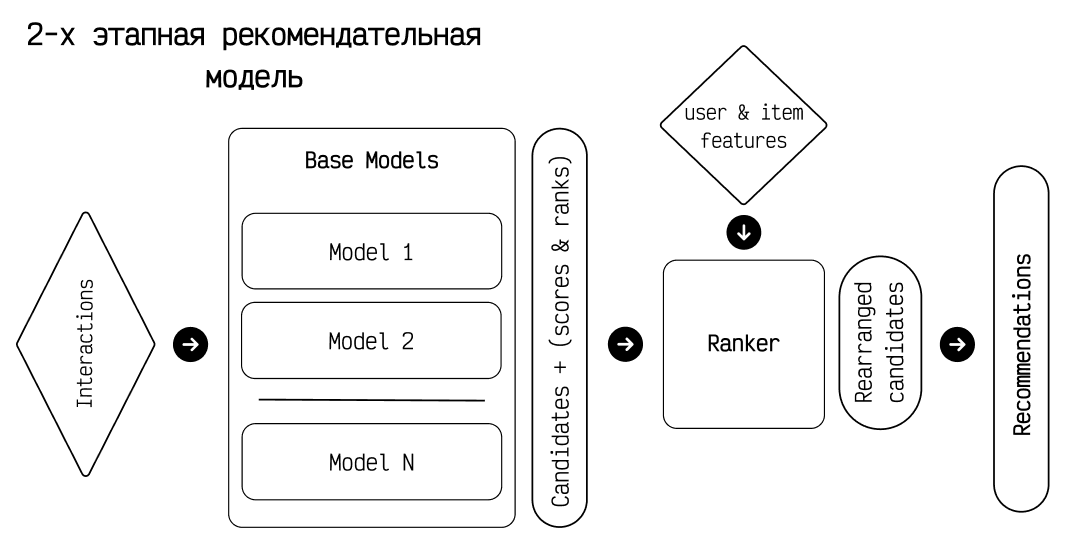

In [2]:
Image("./images/2stagemodel.png")

## Модели первого уровня

Здесь модели должны быть максимально простыми и не учитывали фитчи айтемов, т.е. строились, основываясь на матрице взаимодействий. Также хотелось бы, чтобы модели были разными, т.е. основывались на различных методах. В качестве моделей первого уровня можно рассмотреть: 
- kNN (cosine & BM25)
- MF (ALS)
- FM (LightFM)
- EASE \ SLIM
- DL (SASRec \ Bert4Rec)
- Top Popular
- Last Viewed
- Рекомендации на основе изображений последних, просмотренных товаров (https://habr.com/ru/articles/675052/)



## Модели второго уровня

Данная модель должна учитывать скоры посчитанных товаров, а так же фитчи товаров и пользователей и на основе этого выдавать свой ответ.  В качестве ранкеров можно рассмотреть:

- LightGMB (LGBMRanker)
- CatBoost (CatBoostRanker)

> Модель второго уровня строиться на данных отличных от тех, что были использованы для построения моделей первого уровня
> 
> Планируется использовать ListWise подход для переранжирования

## Валидация

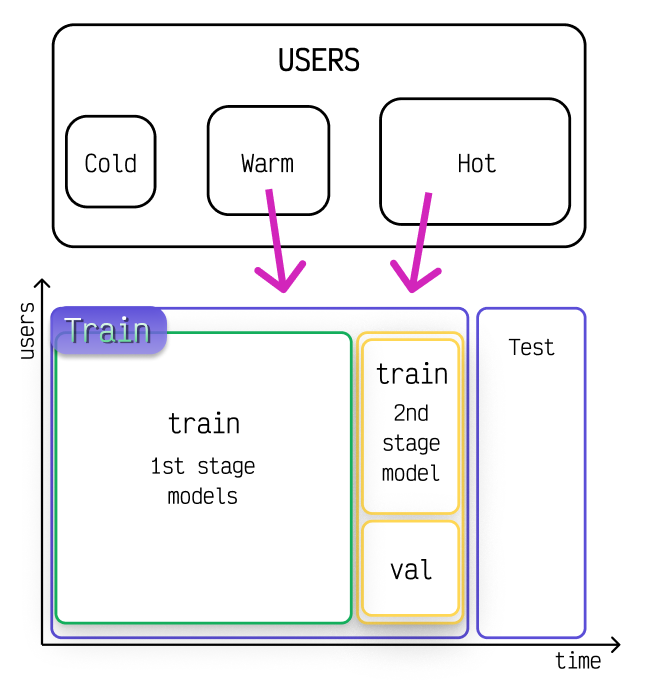

In [3]:
Image("./images/validation.png")

При использовании Time-based валидации, естественно, что появятся Cold-users. Так как у нас отсутствует информация о пользователях, то для холодного старта будет использоваться модель TopPopular.

На оставшихся пользователях и будет обучаться наша модель.  

## Метрики

### Примеры 

- Precision@k
- Recall@k
- AP@k, MAP@k, MNAP@k
- NDCG@k
- MRR
- Coverage - покрытие. Может считаться как по объектам (сколько из них рекомендованы хотя бы раз), так и по пользователям (скольким можем построить персональные рекомендации)
- Novelty - новизна
- Diversity - разнообразие
- Serendipity - “полезная” неожиданность
- Bias - смещение
- Fairness - честность
- Stability - стабильность
- Вероятностные - PFound, Rank-biased Precision


### Будем использовать следующий набор метрик: 

- MAP@k
- Recall@k
- Serendipity
- NDCG
- Novelty

# Обоснование выбора 

1. Учет большего количества информации о пользователях и айтемах.
2. Использовать рекомендации от нескольких моделей.
3. Модель обучается на своих же рекомендациях.
4. Улучшение качества рекомендаций по средствам дополнительного ранжирования.
5. Масштабируемость